**Group information**

| Family name | First name | Email address |
| Tausendschoen | Oliver | oliver.tausendschoen@bse.eu |
|Goar|Gerardo| gerardo.goar@bse.eu|


# Semantic segmentation - Homework

This tutorial explores how to automatically extract building footprints from aerial images. The objective is to perform semantic segmentation, or approximate the function that maps input images to class probabilities for each pixel. For this assignment, we use the U-Net convolutional network architecture [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). The GPU implementation of PyTorch is recommended.

The image dataset consists of 3347 colour images, each with dimensions $3 \times 256 \times 256$, sourced from [Minh (2013)](http://www.cs.toronto.edu/~vmnih/data/). Each image corresponds to a 300-square-metre area within the state of Massachusetts. The labels are building footprint vectors derived from [OpenStreetMap](https://www.openstreetmap.org/relation/61315), which have been rasterised into binary masks matching the spatial extent and resolution of the input images. For efficient storage, images and labels are saved in the JPEG format.

![U-Net model](https://www.dropbox.com/scl/fi/wgvqiix6scbm1c983ephk/segmentation_model.jpg?rlkey=71blfq7cm1yzw26puu4l0ybhs&dl=1)

In [1]:
# Packages
import os
import shutil
import torch
import tqdm

from matplotlib import pyplot as plt
from torch import nn, optim, utils
from torchmetrics import classification
from torchvision import io, ops
from urllib import request
import numpy as np
import os
import torch
from torch import nn, optim, utils
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage import io
from sklearn import metrics
from torch.utils.data import TensorDataset, DataLoader, random_split



# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)

# Utilities
classes = {0:'non-building', 255:'building'}

In [2]:
# Utilities
def download_data():
    if os.getcwd().endswith('/data'):
        print('Data folder already exists')
    else:
        request.urlretrieve('https://www.dropbox.com/scl/fo/90urs56ftly5r28jk18i4/AB2AIFdymQmeEqJZ8Og0V4Q?rlkey=nkb2w0fmfuym7sbgqpqnvm9cd&dl=1', 'data.zip')
        shutil.unpack_archive('data.zip', 'data')
        os.remove('data.zip')
        os.chdir('data')

def display_image(image:torch.Tensor, title:str='', cmap:str='gray', figsize=(5, 5)) -> None:
    image   = torch.einsum('dhw -> hwd', image)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close()


def display_image(image: torch.Tensor, title: str = '', cmap: str = 'gray', figsize=(5, 5)) -> None:
    if image.ndim == 3:
        image = torch.einsum('chw -> hwc', image)  # channels first to last
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image, cmap=cmap)
    ax.set_title(title, fontsize=15)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close()


1. Load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$. Normalise the images and labels between 0 and 1 and set the data type as `torch.float32`.

<small>Note: In the label images, pixel values of 0 indicate non-building areas, while 255 indicate buildings. Due to JPEG's lossy compression, some values may slightly differ from 0 or 255. You can round the pixel values to restore binary labels.</small>

In [3]:
#download_data()

image_dir = 'data/images'
label_dir = 'data/labels'

# File listing
files  = [file.replace('image_', '') for file in os.listdir(image_dir)]
files  = sorted(files)  # ensures image_i matches label_i
print(f'Total files: {len(files)}')

Total files: 3347


In [4]:
transform = transforms.ToTensor() ## Converts to float32 and scales to [0, 1
images = torch.stack([transform(io.imread(f'{image_dir}/image_{file}')) for file in files])
labels = torch.stack([transform(io.imread(f'{label_dir}/label_{file}'))for file in files])  # Binary mask (1 channel)


2. Check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

Images shape: torch.Size([3347, 3, 256, 256])
Labels shape: torch.Size([3347, 1, 256, 256])


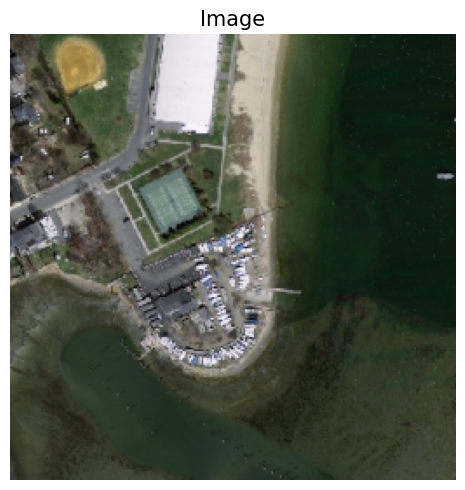

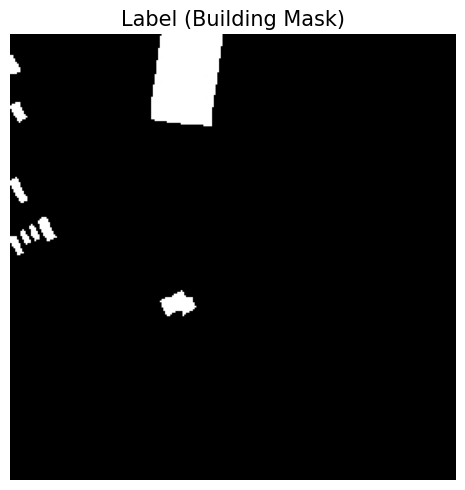

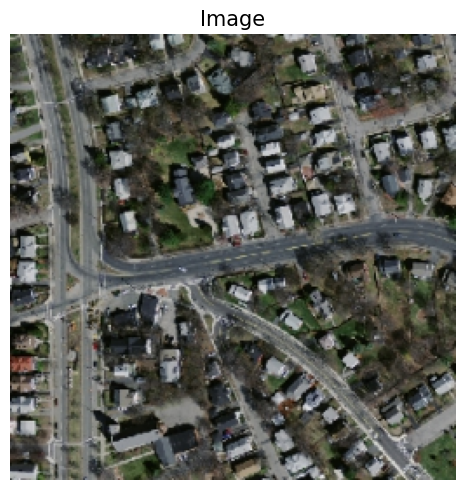

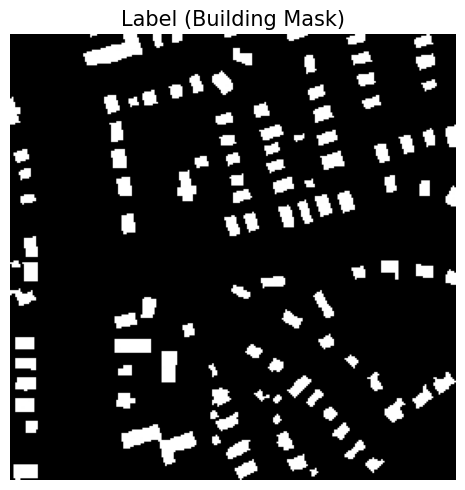

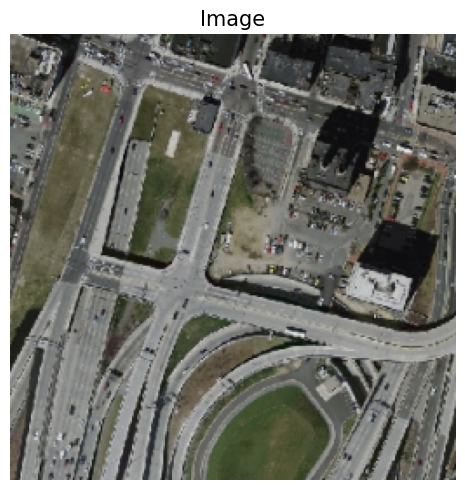

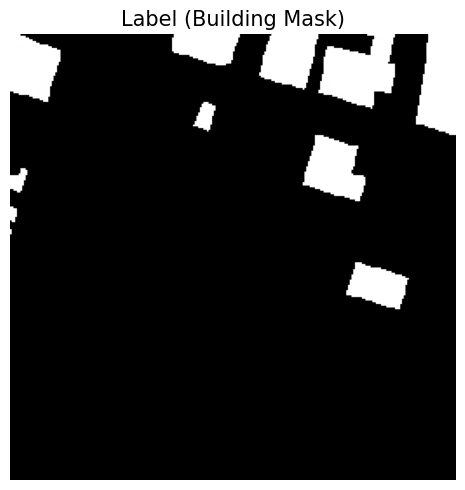

In [5]:
print(f'Images shape: {images.shape}')  # Expect (N, 3, H, W)
print(f'Labels shape: {labels.shape}')  # Expect (N, 1, H, W)

# Display sample
for i in torch.randint(0, len(images), (3,)):
    display_image(image=images[i], title='Image')
    display_image(image=labels[i], title='Label (Building Mask)', cmap='gray')

3. Format the data as a `TensorDataset` and partition the observations into training (75%) and test (25%) samples. For each sample, create a `DataLoader` with a batch size suitable for your hardware (e.g. between 32 and 256).

<small>Note: Optionally, you can also include a validation sample by splitting the dataset into 70% training, 15% validation, and 15% test.</small>

In [6]:
dataset = TensorDataset(images, labels)


# Correctly convert sizes to integers
train_size = int(0.75 * len(dataset))
test_size  = len(dataset) - train_size  # ensures total matches exactly


# Random split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 8  #

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

4. Using PyTorch, define a simplified U-Net model with the number of filters indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). Choose the appropriate activation functions for the hidden layers and the output layer.

<small>Note: Optionally, you can include batch normalisation and spatial dropout layers to improve the model’s optimisation and generalisation, respectively.</small>

For this task, we used: https://medium.com/@alejandro.itoaramendia/decoding-the-u-net-a-complete-guide-810b1c6d56d8 as a rough guideline

Before building the entire architecure, we will define some helper functions to implement the skip connections in the U-Net.

- center_crop:
Crops the input tensor at the center to match the target spatial size. This is needed to ensure that the sizes of the matching connections during skip connections (encoder and decoder block) match exactly!

- skip_connect:
Performs the skip connection by concatenating the upsampled decoder output with the cropped encoder feature map.



In [7]:
import torch
import torch.nn as nn

#Helper function for skip connections, we used CHATGPT to help implement these.
def center_crop(tensor, target_size):
    _, _, h, w = tensor.shape
    target_h, target_w = target_size
    delta_h = (h - target_h) // 2
    delta_w = (w - target_w) // 2
    return tensor[:, :, delta_h:delta_h + target_h, delta_w:delta_w + target_w]

def skip_connect(upsampled, encoder_feature):
    cropped = center_crop(encoder_feature, upsampled.shape[2:])
    return torch.cat([upsampled, cropped], dim=1) #1=channel dimension for concatination


In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.bottleneck = conv_block(512, 1024)

        self.pool = nn.MaxPool2d(2)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()  # Use sigmoid for binary segmentation

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))

        # Decoder with skip connections
        d4 = self.up4(b)
        d4 = self.dec4(skip_connect(d4, e4))

        d3 = self.up3(d4)
        d3 = self.dec3(skip_connect(d3, e3))

        d2 = self.up2(d3)
        d2 = self.dec2(skip_connect(d2, e2))

        d1 = self.up1(d2)
        d1 = self.dec1(skip_connect(d1, e1))

        out = self.out_conv(d1)
        return self.out_activation(out)


5. Initialise the model and print its architecture. Select an appropriate optimisation algorithm and loss function.

<small>Note: To address class imbalance — since building pixels represent only a small fraction of the total — you can weight the loss function or use loss functions specifically designed for imbalance, such as `torchvision.ops.sigmoid_focal_loss`.</small>


In [9]:
model = UNet(in_channels=3, out_channels=1)
model = model.to(device)

# Print model architecture
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

In [10]:
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Weighted Binary Cross-Entropy Loss
# Building pixels are sparse, so we assign more weight to the positive class (buildings = 1)
pos_weight = torch.tensor([5.0]).to(device)  # Tune this value depending on the level of imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


6. Write the PyTorch training routine and estimate the model parameters using the training sample.

Note: If you use a validation sample, implement a validation routine and apply early stopping to prevent overfitting.

In [11]:
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0.0

    for step, (images, masks) in enumerate(train_loader):
        images = images.to(device)               # Shape: (B, 3, H, W)
        masks = masks.to(device)                 # Shape: (B, 1, H, W)

        optimizer.zero_grad()
        logits = model(images)                   # Output: raw logits (B, 1, H, W)
        loss = criterion(logits, masks)          # Compare logits vs masks
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        if step % 100 == 0:
            print(f'Train Epoch: {epoch} [{step * len(images)}/{len(train_loader.dataset)} '
                  f'({100. * step / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Average training loss: {avg_loss:.4f}")

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            loss = criterion(logits, masks)
            test_loss += loss.item() * images.size(0)

    avg_loss = test_loss / len(test_loader.dataset)
    print(f"Test set: Average loss: {avg_loss:.4f}")


In [ ]:
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader, criterion)


Train Epoch: 1 [0/2510 (0%)]	Loss: 1.058846


7. Compute the predicted probabilities for the test images.

8. Assess the model's generalisation performance by computing the confusion matrix, along with precision and recall metrics on the test sample. Comment on the results.

9. Implement a function to visualise true positives, true negatives, false positives, and false negatives as overlays on the input image.

10. Assuming that we give equal importance to reducing false positives and false negatives, use a decision probability threshold that strikes the best balance between these two quantities.